In [2]:
!git clone https://github.com/batuozdas/retina_disease_detection

fatal: destination path 'retina_disease_detection' already exists and is not an empty directory.


In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skimage.feature import hog, greycomatrix, greycoprops
from skimage.filters import threshold_otsu
import cv2, pathlib, os, glob,time
from sklearn import svm, tree, ensemble, linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_curve
import tensorflow as tf
import seaborn as sns
import random

In [4]:
file_names = {'CNV':[], 'DME':[], 'DRUSEN':[], 'NORMAL': []}
label_names = {'CNV':0, 'DME':1, 'DRUSEN':2, 'NORMAL': 3}

for file in file_names.keys():
    file_names[file].append(os.listdir('/content/retina_disease_detection/Retina_OCT_dataset_2/{}/'.format(file)))

In [5]:
IMAGE_SHAPE = (128,128)
X_pro, y_pro = [], []
for labels, images in file_names.items():
    for image in images[0]:
        img = cv2.imread('/content/retina_disease_detection/Retina_OCT_dataset_2/{}/{}'.format(labels,image),1)
        img[img == 255] = 0
        img_copy = np.copy(img)
        blurred_img = cv2.medianBlur(img,ksize=7)
        hsv_img = cv2.cvtColor(blurred_img,cv2.COLOR_BGR2HSV)
        h,s,v = hsv_img[:,:,0], hsv_img[:,:,1], hsv_img[:,:,2]
        clahe = cv2.createCLAHE(clipLimit=1.5,tileGridSize=(8,8))
        img_hist = clahe.apply(v)
        threshold_val = threshold_otsu(img_hist)
        threshold_val, threshold_img = cv2.threshold(img_hist,threshold_val,255,cv2.THRESH_BINARY)
        # Opening operation
        mask = cv2.erode(threshold_img, kernel=np.ones((7, 7)), iterations=1)
        mask2 = cv2.dilate(mask, kernel=np.ones((7, 7)), iterations=1)
        # Closing operation
        mask3 = cv2.dilate(mask2, kernel=np.ones((3, 3)), iterations=1)
        threshold_img_clean = cv2.erode(mask3, kernel=np.ones((3, 3)), iterations=1)
        contours, hierarchy = cv2.findContours(threshold_img_clean, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contour_image = cv2.drawContours(img, contours,-1, (100,120,55), thickness=-1)
        img_copy[contour_image != (100,120,55)] = 0
        resized_img = cv2.resize(img_copy,dsize=IMAGE_SHAPE)
        X_pro.append(resized_img)
        y_pro.append(label_names[labels])

In [15]:
IMAGE_SHAPE = (128,128)
X, y = [], []
for labels, images in file_names.items():
    for image in images[0]:
        img = cv2.imread('/content/retina_disease_detection/Retina_OCT_dataset_2/{}/{}'.format(labels,image),1)
        resized_img = cv2.resize(img,dsize=IMAGE_SHAPE)
        X.append(resized_img)
        y.append(label_names[labels])

In [16]:
X = np.array(X)
y = np.array(y)
X.shape

X_pro = np.array(X_pro)
y_pro = np.array(y_pro)
X_pro.shape

(2000, 128, 128, 3)

In [17]:
#Standart Scaler
scaler = StandardScaler()
num_imgs, row, col, channel = X.shape[0], X.shape[1], X.shape[2], X.shape[3]
X_data = X.reshape((-1,num_imgs))
X_data = scaler.fit_transform(X_data)
X = X_data.reshape((num_imgs, row, col, channel))

scaler_pro = StandardScaler()
num_imgs, row, col, channel = X_pro.shape[0], X_pro.shape[1], X_pro.shape[2], X_pro.shape[3]
X_data_pro = X_pro.reshape((-1,num_imgs))
X_data_pro = scaler.fit_transform(X_data_pro)
X_pro = X_data_pro.reshape((num_imgs, row, col, channel))
X_pro.shape

(2000, 128, 128, 3)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

X_train_pro, X_test_pro, y_train_pro, y_test_pro = train_test_split(X_pro, y_pro, test_size=0.2, random_state=0)
X_val_pro, X_test_pro, y_val_pro, y_test_pro = train_test_split(X_test_pro, y_test_pro, test_size=0.5, random_state=0)
X_train_pro.shape

(1600, 128, 128, 3)

In [19]:
def CNN_model_1(IMAGE_SHAPE):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,(3, 3), padding='same', activation='relu', input_shape = (IMAGE_SHAPE + (3,))),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1536,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

In [20]:
def CNN_model_2(IMAGE_SHAPE):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,(3, 3), padding='same', activation='relu', input_shape = (IMAGE_SHAPE + (3,))),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1536,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

In [21]:
def CNN_model_3(IMAGE_SHAPE):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,(3, 3), padding='same', activation='relu', input_shape = (IMAGE_SHAPE + (3,))),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

        tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(48, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1536,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    return model

In [22]:
# Training for model1
model1 = CNN_model_1(IMAGE_SHAPE)
model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
train1 = model1.fit(X_train, y_train,batch_size=84, epochs=15, validation_data=(X_val,y_val))

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 2s 79ms/step - loss: 1.3911 - accuracy: 0.2881 - val_loss: 1.2853 - val_accuracy: 0.5000
Epoch 2/15
20/20 [==============================] - 1s 62ms/step - loss: 1.1941 - accuracy: 0.4563 - val_loss: 0.9544 - val_accuracy: 0.6100
Epoch 3/15
20/20 [==============================] - 1s 61ms/step - loss: 0.8771 - accuracy: 0.6156 - val_loss: 0.8977 - val_accuracy: 0.5550
Epoch 4/15
20/20 [==============================] - 1s 62ms/step - loss: 0.7793 - accuracy: 0.6725 - val_loss: 0.6747 - val_accuracy: 0.7450
Epoch 5/15
20/20 [==============================] - 1s 62ms/step - loss: 0.5583 - accuracy: 0.7781 - val_loss: 0.5675 - val_accuracy: 0.7800
Epoch 6/15
20/20 [==============================] - 1s 62ms/step - loss: 0.4684 - accuracy: 0.8263 - val_loss: 0.4084 - val_accuracy: 0.8550
Epoch 7/15
20/20 [==============================] - 1s 62ms/step - loss: 0.3188 - accuracy: 0.8844 - val_loss: 0.3183 - val_accuracy: 0.8750
Epoch 8/15
20/20 [======

In [23]:
# Training for model2
model2 = CNN_model_2(IMAGE_SHAPE)
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
train2 = model2.fit(X_train, y_train,batch_size=84, epochs=15, validation_data=(X_val,y_val))

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 3s 96ms/step - loss: 1.3826 - accuracy: 0.3006 - val_loss: 1.3381 - val_accuracy: 0.4300
Epoch 2/15
20/20 [==============================] - 2s 78ms/step - loss: 1.1942 - accuracy: 0.4600 - val_loss: 1.2043 - val_accuracy: 0.4200
Epoch 3/15
20/20 [==============================] - 2s 79ms/step - loss: 0.9229 - accuracy: 0.5919 - val_loss: 0.8479 - val_accuracy: 0.6550
Epoch 4/15
20/20 [==============================] - 2s 79ms/step - loss: 0.6827 - accuracy: 0.7231 - val_loss: 0.7218 - val_accuracy: 0.7250
Epoch 5/15
20/20 [==============================] - 2s 79ms/step - loss: 0.4989 - accuracy: 0.7937 - val_loss: 0.5224 - val_accuracy: 0.8050
Epoch 6/15
20/20 [==============================] - 2s 79ms/step - loss: 0.3817 - accuracy: 0.8594 - val_loss: 0.4450 - val_accuracy: 0.8200
Epoch 7/15
20/20 [==============================] - 2s 79ms/step - loss: 0.3248 - accuracy: 0.8763 - val_loss: 0.3150 - val_accuracy: 0.8700
Epoch 8/15
20/20 [======

In [24]:
# Training for model3
model3 = CNN_model_3(IMAGE_SHAPE)
model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
train3 = model3.fit(X_train, y_train,batch_size=84, epochs=15, validation_data=(X_val,y_val))

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 3s 100ms/step - loss: 1.3621 - accuracy: 0.2862 - val_loss: 1.2978 - val_accuracy: 0.4950
Epoch 2/15
20/20 [==============================] - 2s 85ms/step - loss: 1.1569 - accuracy: 0.4831 - val_loss: 0.8700 - val_accuracy: 0.6100
Epoch 3/15
20/20 [==============================] - 2s 84ms/step - loss: 0.8516 - accuracy: 0.6419 - val_loss: 0.6878 - val_accuracy: 0.7650
Epoch 4/15
20/20 [==============================] - 2s 83ms/step - loss: 0.6609 - accuracy: 0.7437 - val_loss: 1.0603 - val_accuracy: 0.6050
Epoch 5/15
20/20 [==============================] - 2s 85ms/step - loss: 0.5660 - accuracy: 0.7775 - val_loss: 0.5801 - val_accuracy: 0.8200
Epoch 6/15
20/20 [==============================] - 2s 86ms/step - loss: 0.4341 - accuracy: 0.8363 - val_loss: 0.4712 - val_accuracy: 0.8400
Epoch 7/15
20/20 [==============================] - 2s 84ms/step - loss: 0.3256 - accuracy: 0.8800 - val_loss: 0.5344 - val_accuracy: 0.8000
Epoch 8/15
20/20 [=====

In [33]:
# Training for model2 with processed images
model2_pro = CNN_model_2(IMAGE_SHAPE)
model2_pro.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
train2_pro = model2_pro.fit(X_train_pro, y_train_pro,batch_size=84, epochs=15, validation_data=(X_val_pro,y_val_pro))

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 3s 96ms/step - loss: 1.2771 - accuracy: 0.4081 - val_loss: 1.1170 - val_accuracy: 0.5350
Epoch 2/15
20/20 [==============================] - 2s 78ms/step - loss: 0.9070 - accuracy: 0.6025 - val_loss: 0.6637 - val_accuracy: 0.6950
Epoch 3/15
20/20 [==============================] - 2s 78ms/step - loss: 0.7476 - accuracy: 0.6794 - val_loss: 0.6415 - val_accuracy: 0.7500
Epoch 4/15
20/20 [==============================] - 2s 79ms/step - loss: 0.5716 - accuracy: 0.7775 - val_loss: 0.8290 - val_accuracy: 0.6750
Epoch 5/15
20/20 [==============================] - 2s 78ms/step - loss: 0.4894 - accuracy: 0.8144 - val_loss: 0.4098 - val_accuracy: 0.8300
Epoch 6/15
20/20 [==============================] - 2s 83ms/step - loss: 0.3617 - accuracy: 0.8662 - val_loss: 0.4127 - val_accuracy: 0.8200
Epoch 7/15
20/20 [==============================] - 2s 77ms/step - loss: 0.3517 - accuracy: 0.8763 - val_loss: 0.2488 - val_accuracy: 0.8900
Epoch 8/15
20/20 [======

In [34]:
# Testing for model1
test1 = model1.evaluate(X_test, y_test)
y_pred1 = model1.predict(X_test)
y_pred1 = [np.argmax(i) for i in y_pred1]
y_pred1 = np.array(y_pred1)

7/7 [==============================] - 0s 13ms/step - loss: 0.4209 - accuracy: 0.8850


In [35]:
# Testing for model2
test2 = model2.evaluate(X_test, y_test)
y_pred2 = model2.predict(X_test)
y_pred2 = [np.argmax(i) for i in y_pred2]
y_pred2 = np.array(y_pred2)

7/7 [==============================] - 0s 16ms/step - loss: 0.2588 - accuracy: 0.9350


In [36]:
# Testing for model3
test3 = model3.evaluate(X_test, y_test)
y_pred3 = model3.predict(X_test)
y_pred3 = [np.argmax(i) for i in y_pred3]
y_pred3 = np.array(y_pred3)
test3

7/7 [==============================] - 0s 17ms/step - loss: 0.4170 - accuracy: 0.9100


[0.4170319736003876, 0.9100000262260437]

In [37]:
# Testing for model2_pro
test2_pro = model2_pro.evaluate(X_test_pro, y_test_pro)
y_pred2_pro = model2_pro.predict(X_test_pro)
y_pred2_pro = [np.argmax(i) for i in y_pred2_pro]
y_pred2_pro = np.array(y_pred2_pro)

7/7 [==============================] - 0s 16ms/step - loss: 0.3237 - accuracy: 0.9400


In [38]:
# Classification Report for Model1
cr1 = classification_report(y_test, y_pred1, output_dict=True, zero_division=0)
df_cr1 = pd.DataFrame(cr1).transpose()
df_cr1 = df_cr1.rename(index={'0': 'CNV','1': 'DME', '2': 'DRUSEN','3':'NORMAL'})
df_cr1

,precision,recall,f1-score,support
CNV,1.000000,0.963636,0.981481,55.000
DME,0.937500,0.882353,0.909091,51.000
DRUSEN,0.925000,0.725490,0.813187,51.000
NORMAL,0.711864,0.976744,0.823529,43.000
accuracy,0.885000,0.885000,0.885000,0.885
macro avg,0.893591,0.887056,0.881822,200.000
weighted avg,0.902988,0.885000,0.886147,200.000


In [39]:
# Classification Report for Model2
cr2 = classification_report(y_test, y_pred2, output_dict=True, zero_division=0)
df_cr2 = pd.DataFrame(cr2).transpose()
df_cr2 = df_cr2.rename(index={'0': 'CNV','1': 'DME', '2': 'DRUSEN','3':'NORMAL'})
df_cr2

,precision,recall,f1-score,support
CNV,1.000000,0.981818,0.990826,55.000
DME,0.909091,0.980392,0.943396,51.000
DRUSEN,1.000000,0.823529,0.903226,51.000
NORMAL,0.836735,0.953488,0.891304,43.000
accuracy,0.935000,0.935000,0.935000,0.935
macro avg,0.936456,0.934807,0.932188,200.000
weighted avg,0.941716,0.935000,0.934996,200.000


In [40]:
# Classification Report for Model3
cr3 = classification_report(y_test, y_pred3, output_dict=True, zero_division=0)
df_cr3 = pd.DataFrame(cr3).transpose()
df_cr3 = df_cr3.rename(index={'0': 'CNV','1': 'DME', '2': 'DRUSEN','3':'NORMAL'})
df_cr3

,precision,recall,f1-score,support
CNV,1.000000,0.981818,0.990826,55.00
DME,0.901961,0.901961,0.901961,51.00
DRUSEN,0.913043,0.823529,0.865979,51.00
NORMAL,0.816327,0.930233,0.869565,43.00
accuracy,0.910000,0.910000,0.910000,0.91
macro avg,0.907833,0.909385,0.907083,200.00
weighted avg,0.913336,0.910000,0.910258,200.00


In [41]:
# Classification Report for Model2_pro
cr2_pro = classification_report(y_test_pro, y_pred2_pro, output_dict=True, zero_division=0)
df_cr2_pro = pd.DataFrame(cr2_pro).transpose()
df_cr2_pro = df_cr2_pro.rename(index={'0': 'CNV','1': 'DME', '2': 'DRUSEN','3':'NORMAL'})
df_cr2_pro

,precision,recall,f1-score,support
CNV,0.982143,1.000000,0.990991,55.00
DME,0.890909,0.960784,0.924528,51.00
DRUSEN,0.956522,0.862745,0.907216,51.00
NORMAL,0.930233,0.930233,0.930233,43.00
accuracy,0.940000,0.940000,0.940000,0.94
macro avg,0.939952,0.938440,0.938242,200.00
weighted avg,0.941184,0.940000,0.939617,200.00


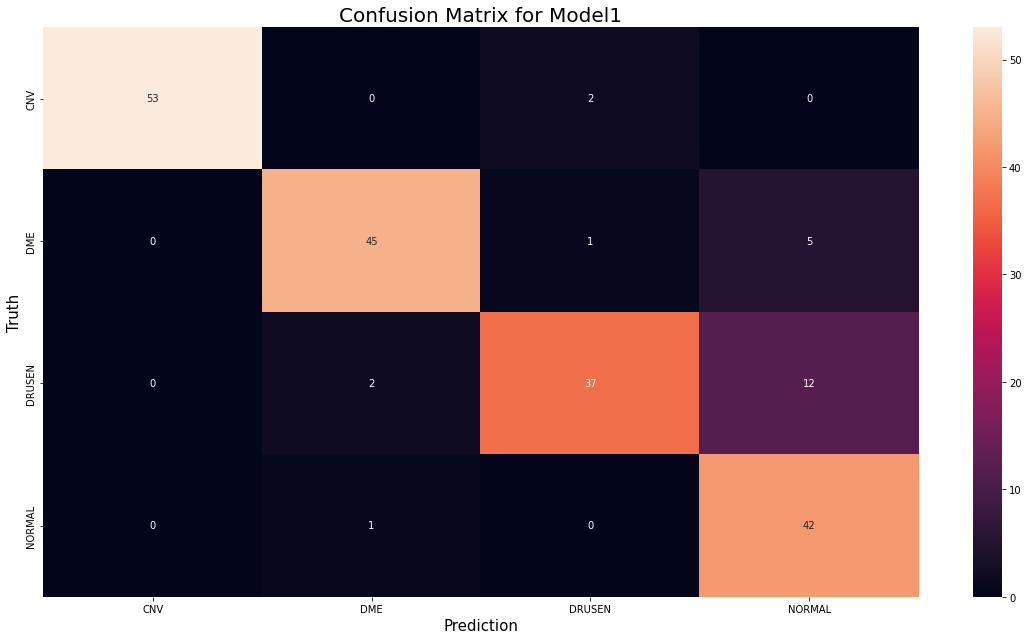

In [42]:
# Plotting Confusion Matrix for Model1
cm1 = confusion_matrix(y_test, y_pred1)
df_cm1 = pd.DataFrame(cm1, index=[i for i, j in label_names.items()], columns=[i for i, j in label_names.items()])
fig = plt.figure(figsize=(16, 9))
sns.heatmap(df_cm1, annot=True, fmt='d')
plt.title('Confusion Matrix for Model1', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.tight_layout()
plt.show()

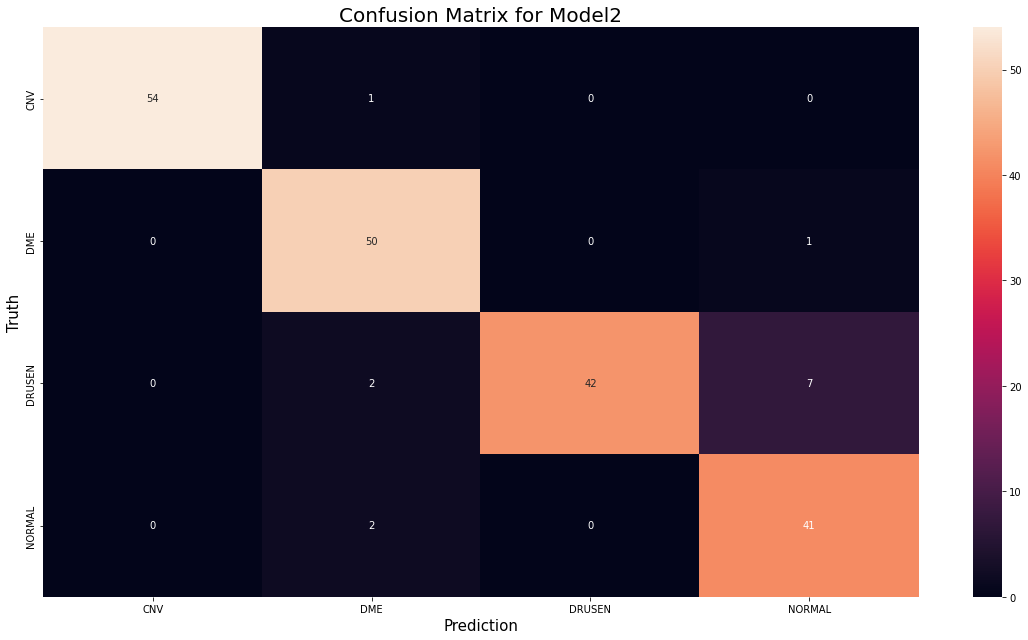

In [43]:
# Plotting Confusion Matrix for Model2
cm2 = confusion_matrix(y_test, y_pred2)
df_cm2 = pd.DataFrame(cm2, index=[i for i, j in label_names.items()], columns=[i for i, j in label_names.items()])
fig = plt.figure(figsize=(16, 9))
sns.heatmap(df_cm2, annot=True, fmt='d')
plt.title('Confusion Matrix for Model2', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.tight_layout()
plt.show()

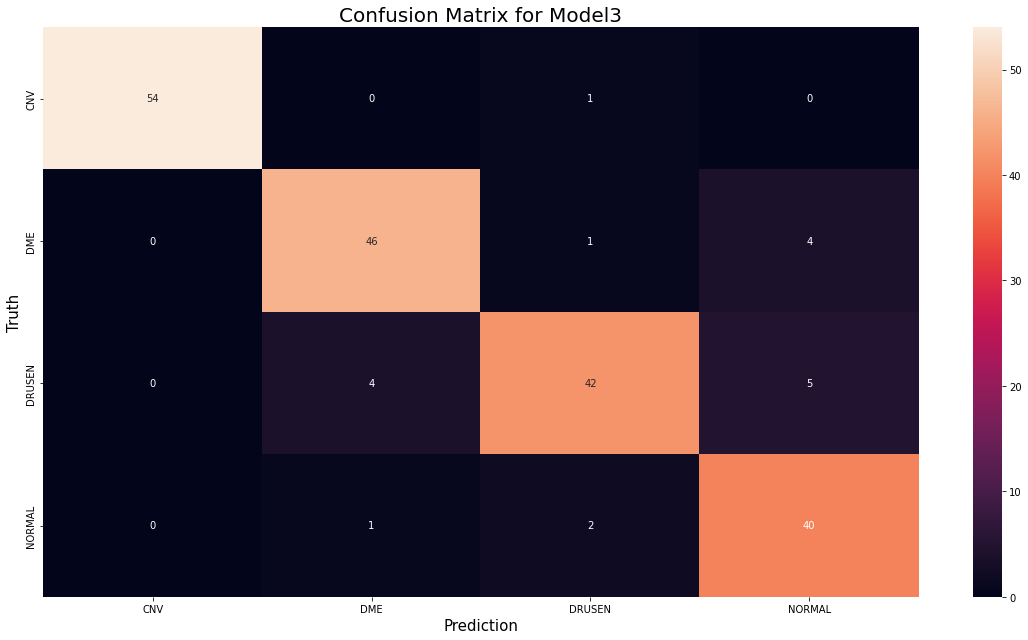

In [44]:
# Plotting Confusion Matrix for Model3
cm3 = confusion_matrix(y_test, y_pred3)
df_cm3 = pd.DataFrame(cm3, index=[i for i, j in label_names.items()], columns=[i for i, j in label_names.items()])
fig = plt.figure(figsize=(16, 9))
sns.heatmap(df_cm3, annot=True, fmt='d')
plt.title('Confusion Matrix for Model3', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.tight_layout()
plt.show()

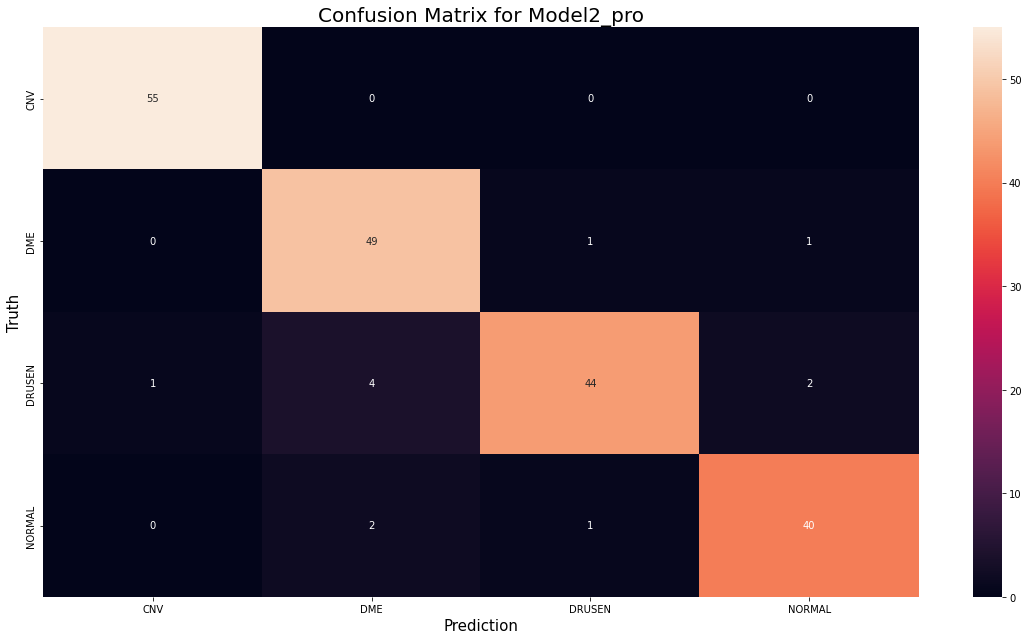

In [46]:
# Plotting Confusion Matrix for Model2_pro
cm2_pro = confusion_matrix(y_test_pro, y_pred2_pro)
df_cm2_pro = pd.DataFrame(cm2_pro, index=[i for i, j in label_names.items()], columns=[i for i, j in label_names.items()])
fig = plt.figure(figsize=(16, 9))
sns.heatmap(df_cm2_pro, annot=True, fmt='d')
plt.title('Confusion Matrix for Model2_pro', fontsize=20)
plt.xlabel('Prediction', fontsize=15)
plt.ylabel('Truth', fontsize=15)
plt.tight_layout()
plt.show()

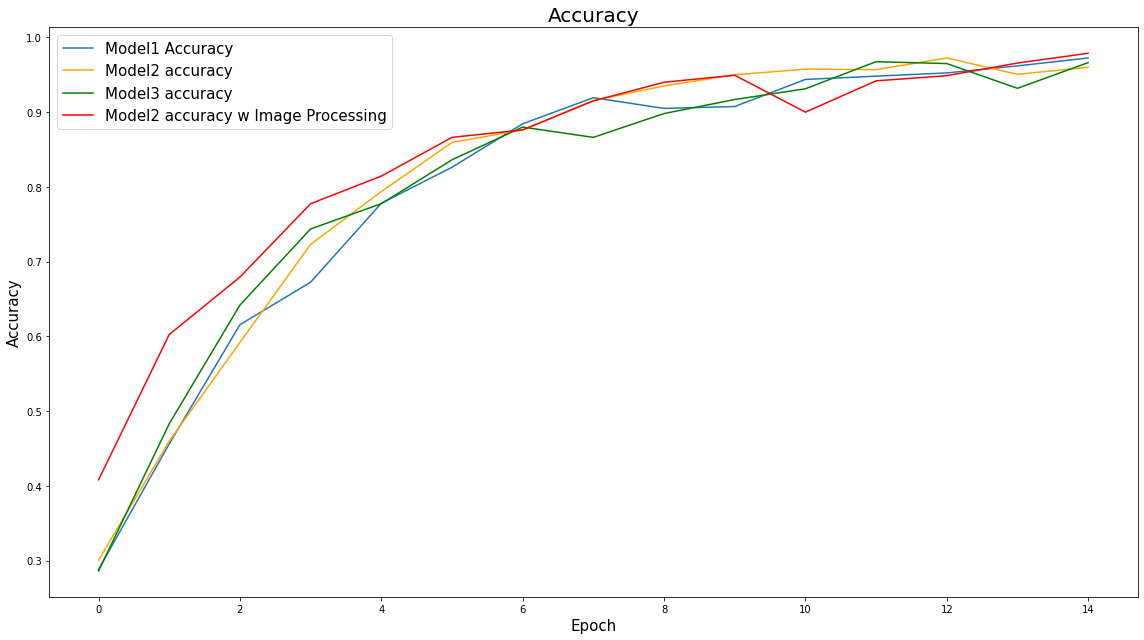

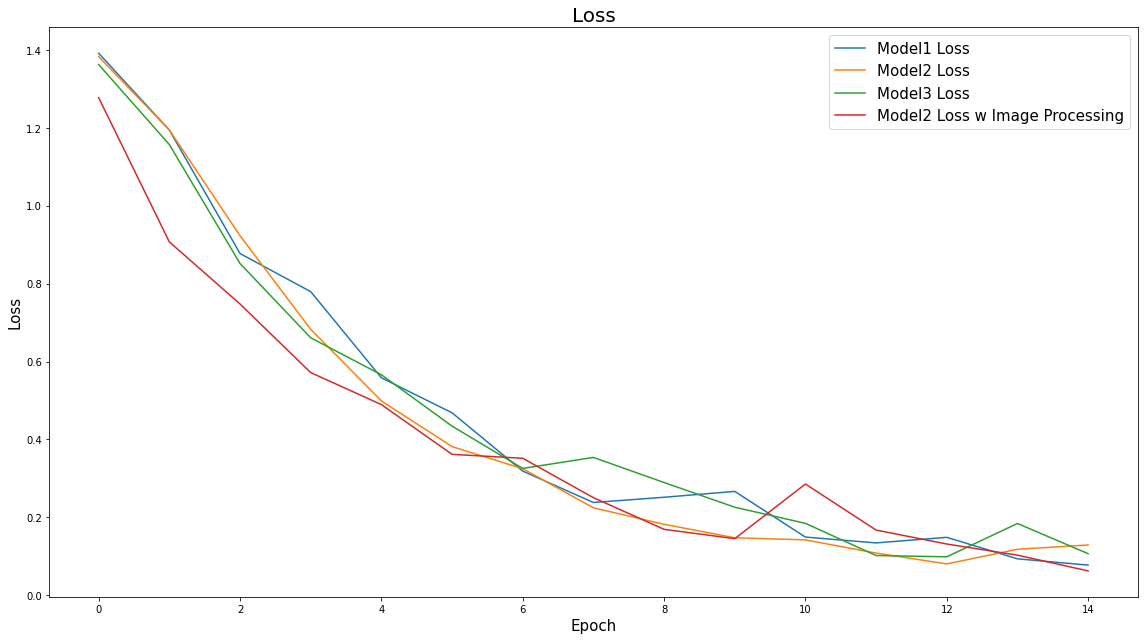

In [47]:
# Plotting training accuracy and loss
n_epochs = len(train1.history['accuracy'])
fig_acc = plt.figure(0, figsize=(16, 9))
plt.plot(range(n_epochs), train1.history['accuracy'], label='Model1 Accuracy')
plt.plot(range(n_epochs), train2.history['accuracy'],color='orange',label='Model2 accuracy')
plt.plot(range(n_epochs), train3.history['accuracy'],color='green',label='Model3 accuracy')
plt.plot(range(n_epochs), train2_pro.history['accuracy'],color='red',label='Model2 accuracy w Image Processing')
plt.title('Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

fig_loss = plt.figure(1, figsize=(16, 9))
plt.plot(range(n_epochs), train1.history['loss'], label='Model1 Loss')
plt.plot(range(n_epochs), train2.history['loss'], label='Model2 Loss')
plt.plot(range(n_epochs), train3.history['loss'], label='Model3 Loss')
plt.plot(range(n_epochs), train2_pro.history['loss'], label='Model2 Loss w Image Processing')
plt.title('Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

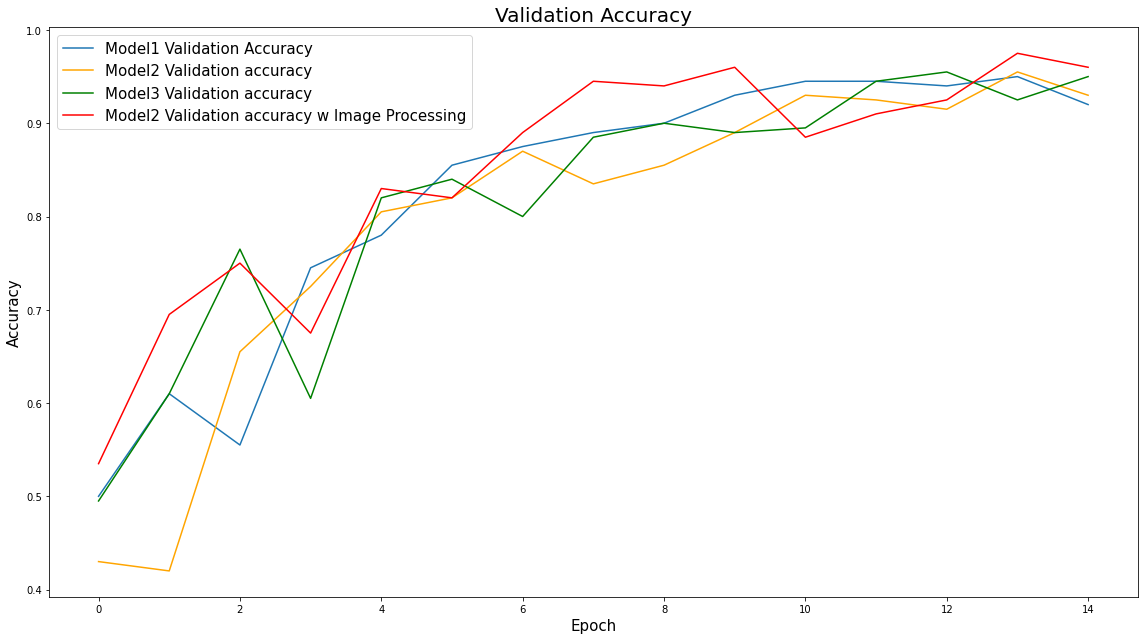

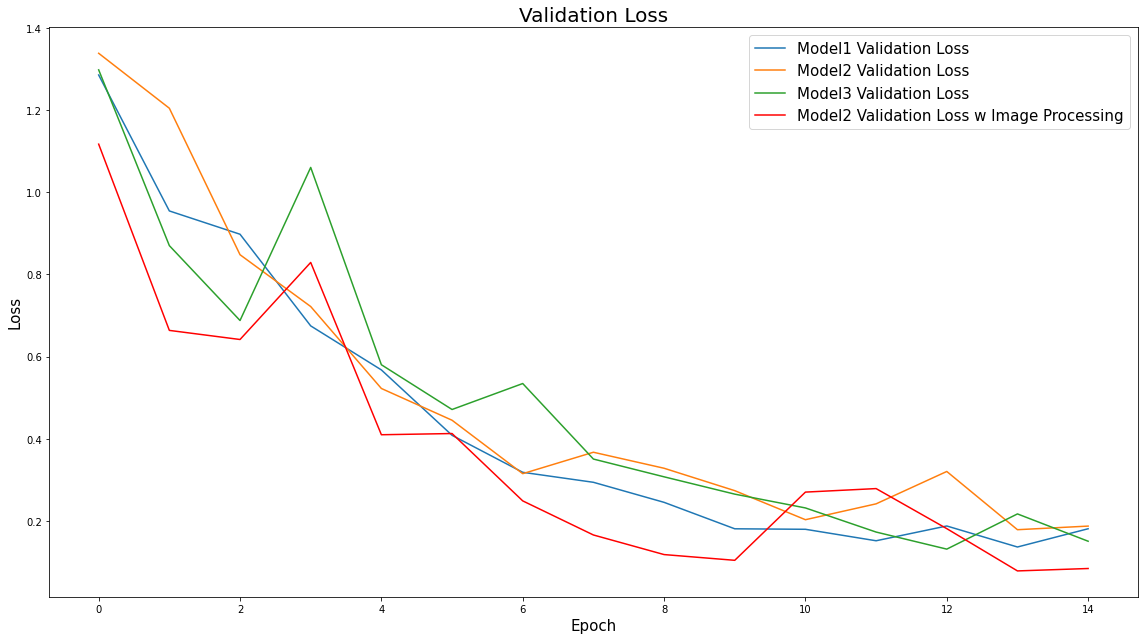

In [48]:
# Plotting validation accuracy and loss
n_epochs = len(train1.history['accuracy'])
fig_acc = plt.figure(0, figsize=(16, 9))
plt.plot(range(n_epochs), train1.history['val_accuracy'], label='Model1 Validation Accuracy')
plt.plot(range(n_epochs), train2.history['val_accuracy'],color='orange',label='Model2 Validation accuracy')
plt.plot(range(n_epochs), train3.history['val_accuracy'],color='green',label='Model3 Validation accuracy')
plt.plot(range(n_epochs), train2_pro.history['val_accuracy'],color='red',label='Model2 Validation accuracy w Image Processing')
plt.title('Validation Accuracy', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

fig_loss = plt.figure(1, figsize=(16, 9))
plt.plot(range(n_epochs), train1.history['val_loss'], label='Model1 Validation Loss')
plt.plot(range(n_epochs), train2.history['val_loss'], label='Model2 Validation Loss')
plt.plot(range(n_epochs), train3.history['val_loss'], label='Model3 Validation Loss')
plt.plot(range(n_epochs), train2_pro.history['val_loss'],color='red',label='Model2 Validation Loss w Image Processing')
plt.title('Validation Loss', fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.show()

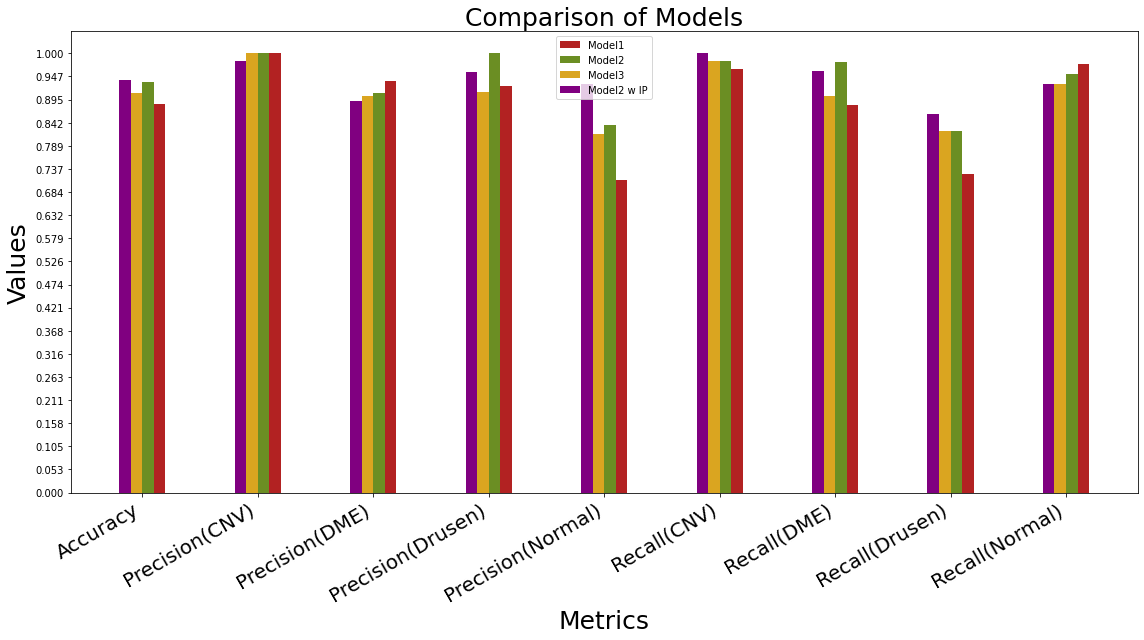

In [53]:
# Comparison of Models
x_labels = ['Accuracy','Precision(CNV)','Precision(DME)','Precision(Drusen)','Precision(Normal)',
            'Recall(CNV)','Recall(DME)','Recall(Drusen)','Recall(Normal)']
x_indexes = np.arange(0,len(x_labels))

y_values = [[test1[1], test2[1], test3[1],test2_pro[1]], 
            [df_cr1.loc['CNV','precision'], df_cr2.loc['CNV','precision'], df_cr3.loc['CNV','precision'], df_cr2_pro.loc['CNV','precision']],
            [df_cr1.loc['DME','precision'], df_cr2.loc['DME','precision'], df_cr3.loc['DME','precision'], df_cr2_pro.loc['DME','precision']],
            [df_cr1.loc['DRUSEN','precision'], df_cr2.loc['DRUSEN','precision'], df_cr3.loc['DRUSEN','precision'], df_cr2_pro.loc['DRUSEN','precision']],
            [df_cr1.loc['NORMAL','precision'], df_cr2.loc['NORMAL','precision'], df_cr3.loc['NORMAL','precision'], df_cr2_pro.loc['NORMAL','precision']],
            [df_cr1.loc['CNV','recall'], df_cr2.loc['CNV','recall'], df_cr3.loc['CNV','recall'], df_cr2_pro.loc['CNV','recall']],
            [df_cr1.loc['DME','recall'], df_cr2.loc['DME','recall'], df_cr3.loc['DME','recall'], df_cr2_pro.loc['DME','recall']],
            [df_cr1.loc['DRUSEN','recall'], df_cr2.loc['DRUSEN','recall'], df_cr3.loc['DRUSEN','recall'], df_cr2_pro.loc['DRUSEN','recall']],
            [df_cr1.loc['NORMAL','recall'], df_cr2.loc['NORMAL','recall'], df_cr3.loc['NORMAL','recall'], df_cr2_pro.loc['NORMAL','recall']]]


width = 0.1
colors = ['firebrick','olivedrab','goldenrod','purple']
labels = ['Model1','Model2','Model3','Model2 w IP']
k = 0
fig = plt.figure(2,figsize=(16,9))
for i in range(len(y_values)):
  val = -1.5
  for j in range(len(y_values[i])):
    plt.bar(x_indexes[k] - val*width,y_values[i][j],width = width, color = colors[j])
    val += 1
  k += 1

plt.xticks(ticks=x_indexes,labels=x_labels,fontsize = 20)
plt.yticks(np.linspace(0,1,20))
plt.title("Comparison of Models",fontsize=25)
plt.xlabel("Metrics",fontsize=25)
plt.ylabel("Values",fontsize=25)
plt.legend(loc='best',labels=labels)
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [67]:
# Predicting random images for model1
labels = list(map(lambda x: 'a', range(0, len(y_test_pro))))
first_labels = [i for i, j in label_names.items()]
for i in range(len(y_test)):
    if y_test_pro[i] == y_pred2_pro[i]:
        labels[i] = first_labels[y_pred2_pro[i]]
    elif y_test_pro[i] == 0 and y_pred2_pro[i] == 1:
        labels[i] = 'True: CNV\nPredict: DME'
    elif y_test_pro[i] == 0 and y_pred2_pro[i] == 2:
        labels[i] = 'True: CNV\nPredict: DRUSEN'
    elif y_test_pro[i] == 0 and y_pred2_pro[i] == 3:
        labels[i] = 'True: CNV\nPredict: NORMAL'
    elif y_test_pro[i] == 1 and y_pred2_pro[i] == 0:
        labels[i] = 'True: DME\nPredict: CNV'
    elif y_test_pro[i] == 1 and y_pred2_pro[i] == 2:
        labels[i] = 'True: DME\nPredict: DRUSEN'
    elif y_test_pro[i] == 1 and y_pred2_pro[i] == 3:
        labels[i] = 'True: DME\nPredict: NORMAL'
    elif y_test_pro[i] == 2 and y_pred2_pro[i] == 0:
        labels[i] = 'True: DRUSEN\nPredict: CNV'
    elif y_test_pro[i] == 2 and y_pred2_pro[i] == 1:
        labels[i] = 'True: DRUSEN\nPredict: DME'
    elif y_test_pro[i] == 2 and y_pred2_pro[i] == 3:
        labels[i] = 'True: DRUSEN\nPredict: NORMAL'
    elif y_test_pro[i] == 3 and y_pred2_pro[i] == 0:
        labels[i] = 'True: NORMAL\nPredict: CNV'
    elif y_test_pro[i] == 3 and y_pred2_pro[i] == 1:
        labels[i] = 'True: NORMAL\nPredict: DME'
    elif y_test_pro[i] == 3 and y_pred2_pro[i] == 2:
        labels[i] = 'True: NORMAL\nPredict: DRUSEN'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

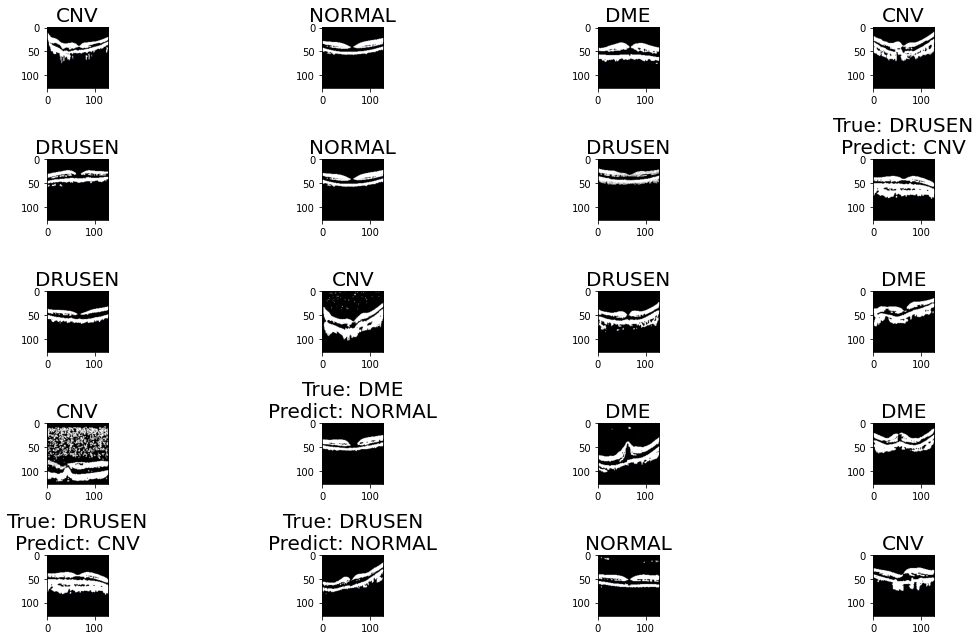

In [69]:
r = 5
c = 4
fig, axes = plt.subplots(r, c, figsize=(16, 9))
for i in range(0, r):
    for j in range(0, c):
        rand = random.randint(0, len(X_test_pro))
        axes[i, j].imshow(X_test_pro[rand])
        axes[i, j].set_title(labels[rand], fontsize=20)
plt.tight_layout()
plt.show()